In [1]:
import pandas as pd
import re
from underthesea import word_tokenize

# Đọc dữ liệu từ file CSV
file_path = 'NLP DATASET.csv'  # Đường dẫn đến file của bạn
data = pd.read_csv(file_path)

# Hàm tiền xử lý câu hỏi
def preprocess_text(text):
    text = text.lower()  # Chuyển về chữ thường
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ dấu câu và ký tự đặc biệt
    tokens = word_tokenize(text)  # Tách từ bằng Underthesea
    return ' '.join(tokens)

# Áp dụng tiền xử lý cho cột Question
data['processed_question'] = data['Question'].apply(preprocess_text)
data.to_csv("Data/Processed_data/svm_processed_data", index=False)
# Kiểm tra kết quả
print(data.head())


   STT                                           Question     Label  \
0    1                    Vì sao mèo ăn những vật thể lạ?       Why   
1    2      Bạn đã chạy được bao nhiêu km trong tuần này?  Quantity   
2    3  Tôi tính làm tủ áo cánh kính cửa lùa, có nên l...    Yes/No   
3    4  Cách phòng ngừa và điều trị Búi lông “Hairball...       How   
4    5  Bạn đã tham gia bao nhiêu buổi tư vấn nghề ngh...  Quantity   

                                  processed_question  
0                     vì sao mèo ăn những vật thể lạ  
1       bạn đã chạy được bao nhiêu km trong tuần này  
2  tôi tính làm tủ áo cánh kính cửa lùa có nên là...  
3  cách phòng ngừa và điều trị búi lông hairball ...  
4  bạn đã tham gia bao nhiêu buổi tư vấn nghề ngh...  


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Tách dữ liệu
X = data['processed_question']
y = data['Label']

# Chia tập dữ liệu thành train và test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

train_data = pd.DataFrame({'Question': X_train, 'Label': y_train})
val_data = pd.DataFrame({'Question': X_val, 'Label': y_val})
test_data = pd.DataFrame({'Question': X_test, 'Label': y_test})

# train_data.to_csv("Data/Train_Test_Val/train_data.csv", index=False)
# val_data.to_csv("Data/Train_Test_Val/val_data.csv", index=False)
# test_data.to_csv("Data/Train_Test_Val/test_data.csv", index=False)

# Trích xuất đặc trưng TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Giới hạn số lượng đặc trưng
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print("Shape của vector TF-IDF (train):", X_train_tfidf.shape)


Shape của vector TF-IDF (train): (768, 1006)


In [9]:
from sklearn.svm import SVC

# Huấn luyện mô hình SVM
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train_tfidf, y_train)



SVC(kernel='linear', random_state=42)

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Đánh giá trên tập validation
y_val_pred = model.predict(X_val_tfidf)
y_val_pred = model.predict(X_val_tfidf)
print("Báo cáo đánh giá trên tập validation:")
print(classification_report(y_val, y_val_pred, zero_division=0))

# Đánh giá trên tập test
y_test_pred = model.predict(X_test_tfidf)
print("Báo cáo đánh giá trên tập test:")
print(classification_report(y_test, y_test_pred, zero_division=0))

Báo cáo đánh giá trên tập validation:
              precision    recall  f1-score   support

         How       0.88      0.81      0.85        27
    Quantity       1.00      0.97      0.98        29
        What       0.71      0.85      0.77        20
        When       0.93      1.00      0.96        25
       Where       0.93      0.78      0.85        18
         Who       0.96      0.96      0.96        28
         Why       1.00      1.00      1.00        29
      Yes/No       0.94      0.94      0.94        16

    accuracy                           0.92       192
   macro avg       0.92      0.91      0.91       192
weighted avg       0.93      0.92      0.92       192

Báo cáo đánh giá trên tập test:
              precision    recall  f1-score   support

         How       0.88      0.93      0.90        40
    Quantity       0.96      1.00      0.98        27
        What       0.89      0.93      0.91        27
        When       1.00      0.91      0.95        34
       W

              precision    recall  f1-score   support

         How       0.88      0.93      0.90        40
    Quantity       0.96      1.00      0.98        27
        What       0.89      0.93      0.91        27
        When       1.00      0.91      0.95        34
       Where       0.97      0.97      0.97        31
         Who       0.97      0.97      0.97        33
         Why       1.00      0.96      0.98        25
      Yes/No       0.91      0.91      0.91        23

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



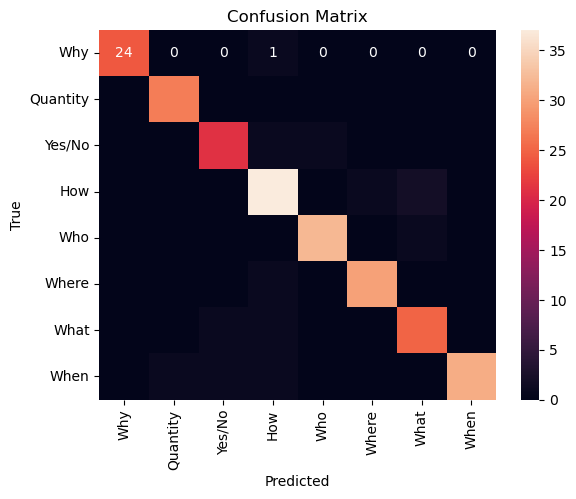

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Báo cáo hiệu năng
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred, labels=y.unique())
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [12]:
import joblib

# Lưu mô hình và vectorizer
joblib.dump(model, 'svm_question_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [13]:
# Tải mô hình
model = joblib.load('svm_question_classifier.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Dự đoán câu hỏi mới
new_question = "Tôi muốn biết tổng thống nước Mỹ bây giờ là ai?"
processed_question = preprocess_text(new_question)
question_vector = vectorizer.transform([processed_question])
predicted_label = model.predict(question_vector)
print("Loại câu hỏi:", predicted_label[0])


Loại câu hỏi: Who
